In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY','929f2ef6945c449c89f4d3dbb7c0cb77')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [6]:
download_url

<function fastdownload.core.download_url(url, dest=None, timeout=None, show_progress=True)>

In [10]:
results.attrgot

<bound method L.attrgot of [{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=grizzly+bear&id=4FE226180F7071D1B3F36B29C2EA074B00E3CBEC&simid=607989609245709244', 'name': 'Grizzly Bear Basic Facts And New Pictures | The Wildlife', 'thumbnailUrl': 'https://tse1.mm.bing.net/th?id=OIP.Mw_Mi-jVWv9_0SNTuiGaSQHaE8&pid=Api', 'datePublished': '2012-10-15T12:00:00.0000000Z', 'isFamilyFriendly': True, 'contentUrl': 'http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg', 'hostPageUrl': 'http://wildlifeanimalz.blogspot.com/2012/10/Grizzly-Bear.html', 'contentSize': '332689 B', 'encodingFormat': 'jpeg', 'hostPageDisplayUrl': 'wildlifeanimalz.blogspot.com/2012/10/Grizzly-Bear.html', 'width': 1600, 'height': 1068, 'hostPageFavIconUrl': 'https://www.bing.com/th?id=ODF.kCKFU1-d0l3Elu2Vvbpmew&pid=Api', 'hostPageDomainFriendlyName': 'blogspot.com', 'hostPageDiscoveredDate': '2012-10-15T12:00:00.0000000Z', 'thumbnail': {'width':

In [11]:
download_images

<function fastai.vision.utils.download_images(dest, url_file=None, urls=None, max_pics=1000, n_workers=8, timeout=4, preserve_filename=False)>

In [9]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [12]:
if not path.exists():
    path.mkdir()
    for bear in bear_types:
        dest = (path/bear)
        dest.mkdir(exist_ok = True)
        results = search_images_bing(key, f'{bear} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [13]:
fns = get_image_files(path)
fns

(#427) [Path('bears/grizzly/00000007.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000002.jpeg'),Path('bears/grizzly/00000000.jpg'),Path('bears/grizzly/00000003.jpg'),Path('bears/grizzly/00000010.jpg'),Path('bears/grizzly/00000011.jpg'),Path('bears/grizzly/00000009.jpg'),Path('bears/grizzly/00000008.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#4) [Path('bears/grizzly/00000035.jpg'),Path('bears/teddy/00000028.jpg'),Path('bears/teddy/00000083.jpg'),Path('bears/teddy/00000101.png')]

In [20]:
failed.map(Path.unlink)

FileNotFoundError: [Errno 2] No such file or directory: 'bears/grizzly/00000035.jpg'

In [24]:
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items= get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [25]:
dls = bears.dataloaders(path)

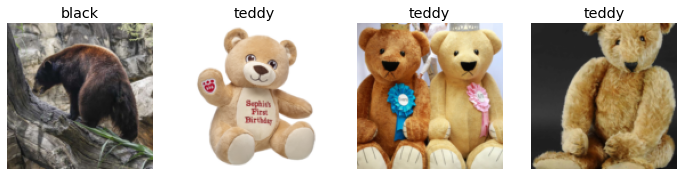

In [26]:
dls.valid.show_batch(max_n=4, nrows=1)

In [28]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [29]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.339492,0.199557,0.071429,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.155699,0.086275,0.023810,00:14
1,0.129046,0.142981,0.023810,00:13
2,0.104786,0.125976,0.023810,00:14
3,0.082381,0.125454,0.023810,00:14


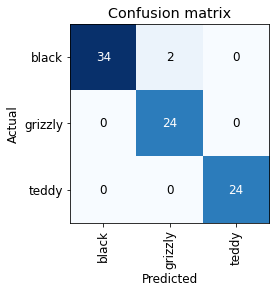

In [30]:
interp= ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

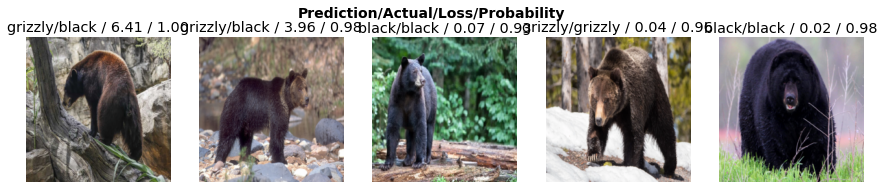

In [31]:
interp.plot_top_losses(5, nrows=1)

In [32]:
learn.export()

In [33]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [36]:
learn_inf = load_learner(path/'export.pkl')